# 🧶 AlphaKnit — Train KnittingTransformer on Colab

**AlphaKnit v6.6-F: Scientific Falsification & Discovery**

Notebook này giúp bạn train mô hình `KnittingTransformer` trên Google Colab với GPU T4/A100.

**Pipeline:** Point Cloud (`.npy`) → Encoder (PointNet) → Transformer Decoder → Edge-Action Sequence (stitch tokens)

---

## 1. 🔧 Setup & Install Dependencies

In [1]:
# Xem tên model CPU
!cat /proc/cpuinfo | grep "model name" | uniq

# Xem tổng quan cấu hình hệ thống
!lscpu

model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
Architecture:                x86_64
  CPU op-mode(s):            32-bit, 64-bit
  Address sizes:             46 bits physical, 48 bits virtual
  Byte Order:                Little Endian
CPU(s):                      2
  On-line CPU(s) list:       0,1
Vendor ID:                   GenuineIntel
  Model name:                Intel(R) Xeon(R) CPU @ 2.20GHz
    CPU family:              6
    Model:                   79
    Thread(s) per core:      2
    Core(s) per socket:      1
    Socket(s):               1
    Stepping:                0
    BogoMIPS:                4400.45
    Flags:                   fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pg
                             e mca cmov pat pse36 clflush mmx fxsr sse sse2 ss h
                             t syscall nx pdpe1gb rdtscp lm constant_tsc rep_goo
                             d nopl xtopology nonstop_tsc cpuid tsc_known_freq p
                             ni pclmulqdq ssse3 fma cx16

In [ ]:
!cd /content/AlphaKnit && git pull

/bin/bash: line 1: cd: /content/AlphaKnit: No such file or directory


In [1]:
# Kiểm tra GPU
!nvidia-smi

import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

Mon Mar  2 05:49:40 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.07              Driver Version: 580.82.07      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   44C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Mount Google Drive (để lưu checkpoints & dataset)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Clone repo từ GitHub (thay URL nếu cần)
# Nếu repo private, dùng: git clone https://<TOKEN>@github.com/user/AlphaKnit.git

import os

REPO_DIR = "/content/AlphaKnit"

if not os.path.exists(REPO_DIR):
    # === OPTION A: Clone từ GitHub ===
    !git clone https://github.com/KiettranFNF002/AlphaKnit-Amigurumi {REPO_DIR}

    # === OPTION B: Copy từ Google Drive ===
    #!cp -r "/content/drive/MyDrive/AlphaKnit" {REPO_DIR}

    print(f"✅ Project ready at {REPO_DIR}")
else:
    print(f"✅ Project already exists at {REPO_DIR}")

Cloning into '/content/AlphaKnit'...
remote: Enumerating objects: 482, done.
remote: Counting objects: 100% (107/107), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 482 (delta 43), reused 72 (delta 28), pack-reused 375 (from 1)
Receiving objects: 100% (482/482), 3.51 MiB | 11.84 MiB/s, done.
Resolving deltas: 100% (232/232), done.
✅ Project ready at /content/AlphaKnit


In [4]:
# Cài dependencies
!pip install -q scipy trimesh networkx webdataset tqdm matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 740.3/740.3 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 9.5 MB/s eta 0:00:00


In [5]:
# Thêm project vào Python path
import sys
sys.path.insert(0, os.path.join(REPO_DIR, "src"))
sys.path.insert(0, os.path.join(REPO_DIR, "scripts"))

# Verify import
from alphaknit import config
from alphaknit.model import KnittingTransformer
from alphaknit.knitting_dataset import KnittingDataset, make_dataloaders

print(f"✅ AlphaKnit imported successfully")
print(f"   Vocab size: {config.VOCAB_SIZE}")
print(f"   D_MODEL: {config.D_MODEL}, N_HEADS: {config.N_HEADS}, N_LAYERS: {config.N_LAYERS}")
print(f"   MAX_SEQ_LEN: {config.MAX_SEQ_LEN}, N_POINTS: {config.N_POINTS}")

✅ AlphaKnit imported successfully
   Vocab size: 8
   D_MODEL: 128, N_HEADS: 4, N_LAYERS: 3
   MAX_SEQ_LEN: 300, N_POINTS: 256


## 2. 🏗️ Generate Dataset (Optional)

Nếu bạn chưa có dataset, chạy cell dưới đây để tạo dataset trực tiếp thành **WebDataset shards** trên Google Drive.

Pipeline: `SpatialGeneratorV2` → `GraphValidator` → `ForwardSimulator` → PCA Align → Tensorize → Pack `.tar` shards

**Ưu điểm WebDataset shards:**
- Tránh giới hạn 100k files của Google Drive FUSE
- I/O streaming nhanh hơn nhiều so với đọc từng file
- Shuffle entropy tốt hơn

> ⚠️ **Thời gian ước tính:** ~5k samples/10 phút trên Colab CPU. 50k samples ≈ 1.5-2 giờ.

In [ ]:
# ============================================================
# CẤU HÌNH DATASET GENERATION
# ============================================================
N_SAMPLES  = 50000   # Tổng số samples cần tạo
SHARD_SIZE = 1000    # Số samples mỗi shard (.tar file)

# Output trên Google Drive (persistent, không mất khi session timeout)
SHARDS_OUTPUT_DIR = "/content/drive/MyDrive/AlphaKnit/data/processed/shards_phase9b_full"

print(f"Will generate {N_SAMPLES} samples into {N_SAMPLES // SHARD_SIZE} shards")
print(f"Output: {SHARDS_OUTPUT_DIR}")

Will generate 50000 samples into 50 shards
Output: /content/drive/MyDrive/AlphaKnit/data/processed/shards_phase9b_full


In [ ]:
import json
import tarfile
import tempfile
import numpy as np
import torch
from tqdm.notebook import tqdm

from alphaknit.dataset_builder import DatasetBuilder
from alphaknit import config
from pack_tensor_dataset import build_tensor_sample

os.makedirs(SHARDS_OUTPUT_DIR, exist_ok=True)

# Check for existing shards — cho phép resume generation
existing_shards = sorted([f for f in os.listdir(SHARDS_OUTPUT_DIR) if f.endswith('.tar')])
if existing_shards:
    print(f"⚠️ Found {len(existing_shards)} existing shards in output dir.")
    print(f"   Last shard: {existing_shards[-1]}")
    resume_from = len(existing_shards)
    samples_already_done = resume_from * SHARD_SIZE
    print(f"   Resuming from shard {resume_from} (≈{samples_already_done} samples done)")
else:
    resume_from = 0
    samples_already_done = 0

remaining = N_SAMPLES - samples_already_done
if remaining <= 0:
    print(f"✅ Already have enough shards ({samples_already_done} ≥ {N_SAMPLES})")
else:
    print(f"\n🚀 Generating {remaining} samples...")
    builder = DatasetBuilder(output_dir="/tmp/_alphaknit_gen_dummy")
    temp_dir = tempfile.mkdtemp()

    skipped = 0
    samples_generated = 0
    shard_id = resume_from

    pbar = tqdm(total=remaining, desc="Generating samples")

    while samples_generated < remaining:
        shard_path = os.path.join(SHARDS_OUTPUT_DIR, f"shard-{shard_id:04d}.tar")
        samples_in_this_shard = min(SHARD_SIZE, remaining - samples_generated)

        with tarfile.open(shard_path, "w") as tar:
            count_in_shard = 0
            while count_in_shard < samples_in_this_shard:
                global_idx = samples_already_done + samples_generated + count_in_shard
                raw_sample = builder._generate_one(global_idx)

                if raw_sample is None:
                    skipped += 1
                    if skipped > N_SAMPLES * 5:
                        print(f"⚠️ Too many skipped samples ({skipped}). Stopping.")
                        break
                    continue

                name = raw_sample['id']
                pc = raw_sample.pop("point_cloud")

                # Tạm lưu JSON + NPY để đi qua tensorizer
                tmp_json = os.path.join(temp_dir, f"{name}.json")
                tmp_npy  = os.path.join(temp_dir, f"{name}.npy")

                with open(tmp_json, "w") as f:
                    json.dump(raw_sample, f)
                np.save(tmp_npy, pc)

                # Tensorize: pad point cloud + build src/tgt token sequences
                tensor_sample = build_tensor_sample(
                    tmp_json, tmp_npy,
                    config.MAX_SEQ_LEN, config.N_POINTS
                )

                # Pack vào tar shard
                tmp_pt = os.path.join(temp_dir, f"{name}.pt")
                torch.save(tensor_sample, tmp_pt)
                tar.add(tmp_pt, arcname=f"{name}.pt")

                # Dọn tmp
                os.remove(tmp_json)
                os.remove(tmp_npy)
                os.remove(tmp_pt)

                count_in_shard += 1
                samples_generated += 1
                pbar.update(1)

        shard_id += 1

    pbar.close()
    os.rmdir(temp_dir)

    total_shards = len([f for f in os.listdir(SHARDS_OUTPUT_DIR) if f.endswith('.tar')])
    print(f"\n🎉 Done! Total: {total_shards} shards, {samples_already_done + samples_generated} samples")
    print(f"   Skipped (invalid): {skipped}")
    print(f"   Saved to: {SHARDS_OUTPUT_DIR}")

NameError: name 'SHARDS_OUTPUT_DIR' is not defined

In [ ]:
# Verify shards
shard_files = sorted([f for f in os.listdir(SHARDS_OUTPUT_DIR) if f.endswith('.tar')])
total_size_mb = sum(os.path.getsize(os.path.join(SHARDS_OUTPUT_DIR, f)) for f in shard_files) / 1e6

print(f"📦 {len(shard_files)} shards | {total_size_mb:.0f} MB total")
for f in shard_files[:5]:
    size = os.path.getsize(os.path.join(SHARDS_OUTPUT_DIR, f)) / 1e6
    print(f"   {f} ({size:.1f} MB)")
if len(shard_files) > 5:
    print(f"   ... ({len(shard_files) - 5} more shards)")

NameError: name 'SHARDS_OUTPUT_DIR' is not defined

## 3. 📦 Dataset Configuration

Dataset gồm WebDataset `.tar` shards, mỗi shard chứa `sample_XXXXX.pt` đã tensorize sẵn:
- `pc`: Point cloud `(N_POINTS, 3)` float32
- `src`: Teacher forcing input `(MAX_SEQ_LEN, 3)` long — `<SOS> + edge_tuples`
- `tgt`: Prediction target `(MAX_SEQ_LEN, 3)` long — `edge_tuples + <EOS>`

In [6]:
# ============================================================
# CẤU HÌNH DATASET PATH
# ============================================================

# WebDataset shards trên Google Drive
DATASET_DIR = "/content/drive/MyDrive/AlphaKnit/data/processed/shards_phase9b_full/shard-{0000..0049}.tar"

# Nếu muốn dùng Map-Style dataset (folder chứa .json + .npy):
# DATASET_DIR = "/content/drive/MyDrive/AlphaKnit/data/processed/dataset"

print(f"Dataset: {DATASET_DIR}")

Dataset: /content/drive/MyDrive/AlphaKnit/data/processed/shards_phase9b_full/shard-{0000..0049}.tar


In [7]:
# Preview 1 sample từ shard
import tarfile
import io

if '.tar' in DATASET_DIR:
    # WebDataset: đọc trực tiếp từ tar
    base_dir = DATASET_DIR.split('{')[0]
    first_shard = base_dir + "0000.tar"
    if os.path.exists(first_shard):
        with tarfile.open(first_shard, 'r') as tar:
            member = tar.getmembers()[0]
            f = tar.extractfile(member)
            sample = torch.load(io.BytesIO(f.read()), map_location='cpu', weights_only=False)

        print(f"Sample from {os.path.basename(first_shard)} → {member.name}")
        print(f"  pc shape:  {sample['pc'].shape}  dtype: {sample['pc'].dtype}")
        print(f"  src shape: {sample['src'].shape}  dtype: {sample['src'].dtype}")
        print(f"  tgt shape: {sample['tgt'].shape}  dtype: {sample['tgt'].dtype}")

        # Decode first few tokens
        print(f"\n  First 5 src tuples (type, p1, p2):")
        for i in range(min(5, sample['src'].shape[0])):
            t, p1, p2 = sample['src'][i].tolist()
            name = config.ID_TO_TOKEN.get(t, f'<ID:{t}>')
            print(f"    [{i}] {name:8s} (p1={p1}, p2={p2})")
    else:
        print(f"⚠️ First shard not found: {first_shard}")
        print(f"   Available files: {os.listdir(os.path.dirname(first_shard))[:5]}")
else:
    # Map-Style: đọc trực tiếp json + npy
    import json
    import numpy as np
    if os.path.isdir(DATASET_DIR):
        sample_files = sorted([f for f in os.listdir(DATASET_DIR) if f.endswith('.json')])
        if sample_files:
            sid = sample_files[0].replace('.json', '')
            with open(os.path.join(DATASET_DIR, f"{sid}.json")) as f:
                meta = json.load(f)
            pc = np.load(os.path.join(DATASET_DIR, f"{sid}.npy"))
            print(f"Sample: {sid}")
            print(f"  Point cloud: {pc.shape}, range [{pc.min():.3f}, {pc.max():.3f}]")
            edge_seq = meta.get('edge_sequence', [])
            print(f"  Edge sequence: {len(edge_seq)} tuples")
            for t, p1, p2 in edge_seq[:5]:
                print(f"    {config.ID_TO_TOKEN.get(t, f'<ID:{t}>')}(p1={p1}, p2={p2})")

Sample from shard-0000.tar → sample_00000.pt
  pc shape:  torch.Size([256, 3])  dtype: torch.float32
  src shape: torch.Size([300, 3])  dtype: torch.int64
  tgt shape: torch.Size([300, 3])  dtype: torch.int64

  First 5 src tuples (type, p1, p2):
    [0] <SOS>    (p1=0, p2=0)
    [1] mr_6     (p1=0, p2=0)
    [2] inc      (p1=6, p2=0)
    [3] inc      (p1=7, p2=0)
    [4] inc      (p1=7, p2=0)


## 4. 🚀 Training Configuration

In [8]:
# ============================================================
# HYPERPARAMETERS — Tối ưu cho Colab T4 (16GB VRAM)
# ============================================================

TRAIN_CONFIG = {
    # Dataset
    "dataset_dir": DATASET_DIR,

    # Checkpoint — Lưu lên Google Drive để không mất khi session timeout
    "checkpoint_dir": "/content/drive/MyDrive/AlphaKnit/checkpoints",
    "run_name": "colab_v6.6F",

    # Model architecture
    "d_model": 128,
    "n_heads": 4,
    "n_layers": 3,
    "ffn_dim": 256,

    # Training
    "epochs": 50,
    "batch_size": 64,          # T4: 64 ok, A100: có thể tăng lên 128-256
    "lr": 1e-3,
    "grad_accum_steps": 2,     # Effective batch = 64 * 2 = 128
    "label_smoothing": 0.1,
    "scheduler_type": "cosine",

    # Data loading
    "num_workers": 2,
    "val_split": 0.1,

    # Phase transition
    "early_stop_patience": 10,
    "log_compile_every": 5,

    # Device
    "device_str": "auto",
}

# Tạo thư mục checkpoint
os.makedirs(TRAIN_CONFIG["checkpoint_dir"], exist_ok=True)
print("✅ Training config ready")
for k, v in TRAIN_CONFIG.items():
    print(f"   {k}: {v}")

✅ Training config ready
   dataset_dir: /content/drive/MyDrive/AlphaKnit/data/processed/shards_phase9b_full/shard-{0000..0049}.tar
   checkpoint_dir: /content/drive/MyDrive/AlphaKnit/checkpoints
   run_name: colab_v6.6F
   d_model: 128
   n_heads: 4
   n_layers: 3
   ffn_dim: 256
   epochs: 50
   batch_size: 64
   lr: 0.001
   grad_accum_steps: 2
   label_smoothing: 0.1
   scheduler_type: cosine
   num_workers: 2
   val_split: 0.1
   early_stop_patience: 10
   log_compile_every: 5
   device_str: auto


## 5. 🏋️ Train Model

In [ ]:
from alphaknit.train import train

# ▶ BẮT ĐẦU TRAINING
history = train(**TRAIN_CONFIG)

print(f"\n🎉 Training complete! {len(history)} epochs recorded.")
print(f"📁 Checkpoints saved to: {TRAIN_CONFIG['checkpoint_dir']}")

Training on: cuda
Loaded WebDataset shards: 45 Train | 5 Val
Train batches: WebDataset Stream | Val batches: Unknown
Model parameters: 930,649
🔒 OBSERVER DECOUPLING: HiddenProbePool initialized with 3 pools.


✨ VERIFIED: Discovery 'Functional_Crystallization' met persistence threshold (41.86/5.00)
⚠️ REJECTED: Discovery 'Functional_Crystallization' rejected by Null Control at epoch ?.
⚠️ REJECTED: Discovery 'Functional_Crystallization' rejected by Shadow Path (Delta=0.0000).
✅ DISCOVERY: Functional_Crystallization: VERIFIED (41.86/5.00)


Epoch   1/50 | loss=3.1334 | val=1.6163 | lag=1.000 | compile=100.0%


✨ VERIFIED: Discovery 'Rank_Collapse' met persistence threshold (37.00/5.00)
✨ VERIFIED: Discovery 'Functional_Crystallization' met persistence threshold (78.86/5.00)
⚠️ REJECTED: Discovery 'Rank_Collapse' rejected by Null Control at epoch ?.
⚠️ REJECTED: Discovery 'Rank_Collapse' rejected by Shadow Path (Delta=0.0000).
⚠️ REJECTED: Discovery 'Functional_Crystallization' rejected by Null Control at epoch ?.
⚠️ REJECTED: Discovery 'Functional_Crystallization' rejected by Shadow Path (Delta=0.0000).
✅ DISCOVERY: Rank_Collapse: VERIFIED (37.00/5.00)
✅ DISCOVERY: Functional_Crystallization: VERIFIED (78.86/5.00)


Epoch   2/50 | loss=2.2636 | val=1.4833 | lag=1.000 | compile=100.0%


✨ VERIFIED: Discovery 'Rank_Collapse' met persistence threshold (113.91/5.00)
✨ VERIFIED: Discovery 'Functional_Crystallization' met persistence threshold (155.76/5.00)
⚠️ REJECTED: Discovery 'Rank_Collapse' rejected by Null Control at epoch ?.
⚠️ REJECTED: Discovery 'Rank_Collapse' rejected by Shadow Path (Delta=0.0000).
⚠️ REJECTED: Discovery 'Functional_Crystallization' rejected by Null Control at epoch ?.
⚠️ REJECTED: Discovery 'Functional_Crystallization' rejected by Shadow Path (Delta=0.0000).
✅ DISCOVERY: Rank_Collapse: VERIFIED (113.91/5.00)
✅ DISCOVERY: Functional_Crystallization: VERIFIED (155.76/5.00)


Epoch   3/50 | loss=1.8612 | val=1.2874 | lag=1.000 | compile=100.0%


✨ VERIFIED: Discovery 'Rank_Collapse' met persistence threshold (163.50/5.00)
✨ VERIFIED: Discovery 'Functional_Crystallization' met persistence threshold (205.35/5.00)
⚠️ REJECTED: Discovery 'Rank_Collapse' rejected by Null Control at epoch ?.
⚠️ REJECTED: Discovery 'Rank_Collapse' rejected by Shadow Path (Delta=0.0000).
⚠️ REJECTED: Discovery 'Functional_Crystallization' rejected by Null Control at epoch ?.
⚠️ REJECTED: Discovery 'Functional_Crystallization' rejected by Shadow Path (Delta=0.0000).
✅ DISCOVERY: Rank_Collapse: VERIFIED (163.50/5.00)
✅ DISCOVERY: Functional_Crystallization: VERIFIED (205.35/5.00)


Epoch   4/50 | loss=1.6949 | val=1.2479 | lag=1.000 | compile=100.0%
📈 NEW EMERGENCE PEAK: Velocity 0.0283, Accel 0.0491 at Epoch 4


✨ VERIFIED: Discovery 'Rank_Collapse' met persistence threshold (209.81/5.00)
✨ VERIFIED: Discovery 'Functional_Crystallization' met persistence threshold (251.67/5.00)
⚠️ REJECTED: Discovery 'Rank_Collapse' rejected by Null Control at epoch ?.
⚠️ REJECTED: Discovery 'Rank_Collapse' rejected by Shadow Path (Delta=0.0000).
⚠️ REJECTED: Discovery 'Functional_Crystallization' rejected by Null Control at epoch ?.
⚠️ REJECTED: Discovery 'Functional_Crystallization' rejected by Shadow Path (Delta=0.0000).
✅ DISCOVERY: Rank_Collapse: VERIFIED (209.81/5.00)
✅ DISCOVERY: Functional_Crystallization: VERIFIED (251.67/5.00)


Epoch   5/50 | loss=1.5815 | val=1.1592 | lag=1.000 | compile=100.0%
📈 NEW EMERGENCE PEAK: Velocity 0.0300, Accel 0.0017 at Epoch 5


✨ VERIFIED: Discovery 'Rank_Collapse' met persistence threshold (258.90/5.00)
✨ VERIFIED: Discovery 'Functional_Crystallization' met persistence threshold (300.76/5.00)
⚠️ REJECTED: Discovery 'Rank_Collapse' rejected by Null Control at epoch ?.
⚠️ REJECTED: Discovery 'Rank_Collapse' rejected by Shadow Path (Delta=0.0000).
⚠️ REJECTED: Discovery 'Functional_Crystallization' rejected by Null Control at epoch ?.
⚠️ REJECTED: Discovery 'Functional_Crystallization' rejected by Shadow Path (Delta=0.0000).
✅ DISCOVERY: Rank_Collapse: VERIFIED (258.90/5.00)
✅ DISCOVERY: Functional_Crystallization: VERIFIED (300.76/5.00)


Epoch   6/50 | loss=1.5926 | val=1.1688 | lag=1.000 | compile=100.0%


✨ VERIFIED: Discovery 'Rank_Collapse' met persistence threshold (306.46/5.00)
✨ VERIFIED: Discovery 'Functional_Crystallization' met persistence threshold (348.31/5.00)
⚠️ REJECTED: Discovery 'Rank_Collapse' rejected by Null Control at epoch ?.
⚠️ REJECTED: Discovery 'Rank_Collapse' rejected by Shadow Path (Delta=0.0000).
⚠️ REJECTED: Discovery 'Functional_Crystallization' rejected by Null Control at epoch ?.
⚠️ REJECTED: Discovery 'Functional_Crystallization' rejected by Shadow Path (Delta=0.0000).
✅ DISCOVERY: Rank_Collapse: VERIFIED (306.46/5.00)
✅ DISCOVERY: Functional_Crystallization: VERIFIED (348.31/5.00)


Epoch   7/50 | loss=1.4840 | val=1.0788 | lag=1.000 | compile=100.0%


✨ VERIFIED: Discovery 'Rank_Collapse' met persistence threshold (361.41/5.00)
✨ VERIFIED: Discovery 'Functional_Crystallization' met persistence threshold (403.27/5.00)
⚠️ REJECTED: Discovery 'Rank_Collapse' rejected by Null Control at epoch ?.
⚠️ REJECTED: Discovery 'Rank_Collapse' rejected by Shadow Path (Delta=0.0000).
⚠️ REJECTED: Discovery 'Functional_Crystallization' rejected by Null Control at epoch ?.
⚠️ REJECTED: Discovery 'Functional_Crystallization' rejected by Shadow Path (Delta=0.0000).
✅ DISCOVERY: Rank_Collapse: VERIFIED (361.41/5.00)
✅ DISCOVERY: Functional_Crystallization: VERIFIED (403.27/5.00)


Epoch   8/50 | loss=1.4123 | val=1.0538 | lag=1.000 | compile=100.0%
💎 CRYSTALLIZATION DETECTED! Saving Golden Checkpoint: /content/drive/MyDrive/AlphaKnit/checkpoints/golden_epoch_008.pt


✨ VERIFIED: Discovery 'Functional_Crystallization' met persistence threshold (458.32/5.00)
⚠️ REJECTED: Discovery 'Functional_Crystallization' rejected by Null Control at epoch ?.
⚠️ REJECTED: Discovery 'Functional_Crystallization' rejected by Shadow Path (Delta=0.0000).
✅ DISCOVERY: Functional_Crystallization: VERIFIED (458.32/5.00)


Epoch   9/50 | loss=1.3040 | val=0.9414 | lag=1.000 | compile=100.0%
📈 NEW EMERGENCE PEAK: Velocity 0.0417, Accel 0.0620 at Epoch 9


✨ VERIFIED: Discovery 'Functional_Crystallization' met persistence threshold (513.43/5.00)
⚠️ REJECTED: Discovery 'Functional_Crystallization' rejected by Null Control at epoch ?.
⚠️ REJECTED: Discovery 'Functional_Crystallization' rejected by Shadow Path (Delta=0.0000).
✅ DISCOVERY: Functional_Crystallization: VERIFIED (513.43/5.00)


Epoch  10/50 | loss=1.2039 | val=0.8321 | lag=1.000 | compile=100.0%
📈 NEW EMERGENCE PEAK: Velocity 0.1039, Accel 0.0622 at Epoch 10


✨ VERIFIED: Discovery 'Functional_Crystallization' met persistence threshold (569.46/5.00)
⚠️ REJECTED: Discovery 'Functional_Crystallization' rejected by Null Control at epoch ?.
⚠️ REJECTED: Discovery 'Functional_Crystallization' rejected by Shadow Path (Delta=0.0000).
✅ DISCOVERY: Functional_Crystallization: VERIFIED (569.46/5.00)


Epoch  11/50 | loss=1.0909 | val=0.7795 | lag=1.000 | compile=100.0%


✨ VERIFIED: Discovery 'Functional_Crystallization' met persistence threshold (622.82/5.00)
⚠️ REJECTED: Discovery 'Functional_Crystallization' rejected by Null Control at epoch ?.
⚠️ REJECTED: Discovery 'Functional_Crystallization' rejected by Shadow Path (Delta=0.0000).
✅ DISCOVERY: Functional_Crystallization: VERIFIED (622.82/5.00)


Epoch  12/50 | loss=1.0527 | val=0.7849 | lag=1.000 | compile=100.0%


✨ VERIFIED: Discovery 'Functional_Crystallization' met persistence threshold (674.77/5.00)
⚠️ REJECTED: Discovery 'Functional_Crystallization' rejected by Null Control at epoch ?.
⚠️ REJECTED: Discovery 'Functional_Crystallization' rejected by Shadow Path (Delta=0.0000).
✅ DISCOVERY: Functional_Crystallization: VERIFIED (674.77/5.00)


Epoch  13/50 | loss=0.9930 | val=0.7290 | lag=1.000 | compile=100.0%
💎 CRYSTALLIZATION DETECTED! Saving Golden Checkpoint: /content/drive/MyDrive/AlphaKnit/checkpoints/golden_epoch_013.pt


✨ VERIFIED: Discovery 'Functional_Crystallization' met persistence threshold (731.24/5.00)
⚠️ REJECTED: Discovery 'Functional_Crystallization' rejected by Null Control at epoch ?.
⚠️ REJECTED: Discovery 'Functional_Crystallization' rejected by Shadow Path (Delta=0.0000).
✅ DISCOVERY: Functional_Crystallization: VERIFIED (731.24/5.00)


Epoch  14/50 | loss=0.9698 | val=0.7092 | lag=1.000 | compile=100.0%
💎 CRYSTALLIZATION DETECTED! Saving Golden Checkpoint: /content/drive/MyDrive/AlphaKnit/checkpoints/golden_epoch_014.pt


✨ VERIFIED: Discovery 'Functional_Crystallization' met persistence threshold (787.93/5.00)
⚠️ REJECTED: Discovery 'Functional_Crystallization' rejected by Null Control at epoch ?.
⚠️ REJECTED: Discovery 'Functional_Crystallization' rejected by Shadow Path (Delta=0.0000).
✅ DISCOVERY: Functional_Crystallization: VERIFIED (787.93/5.00)


Epoch  15/50 | loss=0.9635 | val=0.7089 | lag=1.000 | compile=100.0%
💎 CRYSTALLIZATION DETECTED! Saving Golden Checkpoint: /content/drive/MyDrive/AlphaKnit/checkpoints/golden_epoch_015.pt


✨ VERIFIED: Discovery 'Functional_Crystallization' met persistence threshold (840.74/5.00)
⚠️ REJECTED: Discovery 'Functional_Crystallization' rejected by Null Control at epoch ?.
⚠️ REJECTED: Discovery 'Functional_Crystallization' rejected by Shadow Path (Delta=0.0000).
✅ DISCOVERY: Functional_Crystallization: VERIFIED (840.74/5.00)


Epoch  16/50 | loss=0.9009 | val=0.6732 | lag=1.000 | compile=100.0%


✨ VERIFIED: Discovery 'Functional_Crystallization' met persistence threshold (897.12/5.00)
⚠️ REJECTED: Discovery 'Functional_Crystallization' rejected by Null Control at epoch ?.
⚠️ REJECTED: Discovery 'Functional_Crystallization' rejected by Shadow Path (Delta=0.0000).
✅ DISCOVERY: Functional_Crystallization: VERIFIED (897.12/5.00)


Epoch  17/50 | loss=0.8736 | val=0.6526 | lag=1.000 | compile=100.0%


✨ VERIFIED: Discovery 'Functional_Crystallization' met persistence threshold (952.78/5.00)
⚠️ REJECTED: Discovery 'Functional_Crystallization' rejected by Null Control at epoch ?.
⚠️ REJECTED: Discovery 'Functional_Crystallization' rejected by Shadow Path (Delta=0.0000).
✅ DISCOVERY: Functional_Crystallization: VERIFIED (952.78/5.00)


Epoch  18/50 | loss=0.8587 | val=0.6249 | lag=1.000 | compile=100.0%


✨ VERIFIED: Discovery 'Rank_Collapse' met persistence threshold (58.53/5.00)
✨ VERIFIED: Discovery 'Functional_Crystallization' met persistence threshold (1011.31/5.00)
⚠️ REJECTED: Discovery 'Rank_Collapse' rejected by Null Control at epoch ?.
⚠️ REJECTED: Discovery 'Rank_Collapse' rejected by Shadow Path (Delta=0.0000).
⚠️ REJECTED: Discovery 'Functional_Crystallization' rejected by Null Control at epoch ?.
⚠️ REJECTED: Discovery 'Functional_Crystallization' rejected by Shadow Path (Delta=0.0000).
✅ DISCOVERY: Rank_Collapse: VERIFIED (58.53/5.00)
✅ DISCOVERY: Functional_Crystallization: VERIFIED (1011.31/5.00)


Epoch  19/50 | loss=0.8467 | val=0.6045 | lag=1.000 | compile=100.0%


✨ VERIFIED: Discovery 'Functional_Crystallization' met persistence threshold (1073.20/5.00)
⚠️ REJECTED: Discovery 'Functional_Crystallization' rejected by Null Control at epoch ?.
⚠️ REJECTED: Discovery 'Functional_Crystallization' rejected by Shadow Path (Delta=0.0000).
✅ DISCOVERY: Functional_Crystallization: VERIFIED (1073.20/5.00)


Epoch  20/50 | loss=0.8185 | val=0.5905 | lag=1.000 | compile=100.0%


✨ VERIFIED: Discovery 'Rank_Collapse' met persistence threshold (60.77/5.00)
✨ VERIFIED: Discovery 'Functional_Crystallization' met persistence threshold (1133.97/5.00)
⚠️ REJECTED: Discovery 'Rank_Collapse' rejected by Null Control at epoch ?.
⚠️ REJECTED: Discovery 'Rank_Collapse' rejected by Shadow Path (Delta=0.0000).
⚠️ REJECTED: Discovery 'Functional_Crystallization' rejected by Null Control at epoch ?.
⚠️ REJECTED: Discovery 'Functional_Crystallization' rejected by Shadow Path (Delta=0.0000).
✅ DISCOVERY: Rank_Collapse: VERIFIED (60.77/5.00)
✅ DISCOVERY: Functional_Crystallization: VERIFIED (1133.97/5.00)


Epoch  21/50 | loss=0.7928 | val=0.5804 | lag=1.000 | compile=100.0%


✨ VERIFIED: Discovery 'Rank_Collapse' met persistence threshold (122.93/5.00)
✨ VERIFIED: Discovery 'Functional_Crystallization' met persistence threshold (1196.13/5.00)
⚠️ REJECTED: Discovery 'Rank_Collapse' rejected by Null Control at epoch ?.
⚠️ REJECTED: Discovery 'Rank_Collapse' rejected by Shadow Path (Delta=0.0000).
⚠️ REJECTED: Discovery 'Functional_Crystallization' rejected by Null Control at epoch ?.
⚠️ REJECTED: Discovery 'Functional_Crystallization' rejected by Shadow Path (Delta=0.0000).
✅ DISCOVERY: Rank_Collapse: VERIFIED (122.93/5.00)
✅ DISCOVERY: Functional_Crystallization: VERIFIED (1196.13/5.00)


Epoch  22/50 | loss=0.7759 | val=0.5845 | lag=1.000 | compile=100.0%


Epoch 23: 154it [01:11,  2.48it/s]

## 6. 🔄 Resume Training (nếu bị ngắt giữa chừng)

Nếu Colab session bị timeout, chạy lại từ **Cell 1 (Setup)** rồi nhảy thẳng xuống đây.

In [ ]:
from alphaknit.train import train

RESUME_CONFIG = {
    **TRAIN_CONFIG,
    "resume_auto": True,       # Tự tìm checkpoint mới nhất
    "epochs": 100,             # Tổng epochs muốn đạt được
    # "force_phase2": True,    # Uncomment nếu muốn force Physics phase
    # "reset_optimizer": True, # Uncomment nếu muốn reset optimizer cho phase transition
}

history = train(**RESUME_CONFIG)

print(f"\n🎉 Resumed training complete! {len(history)} epochs recorded.")

Training on: cuda
Loaded WebDataset shards: 45 Train | 5 Val
Train batches: WebDataset Stream | Val batches: Unknown
Model parameters: 930,649
🔒 OBSERVER DECOUPLING: HiddenProbePool initialized with 3 pools.
🔍 Auto-Resume: Detected latest checkpoint at /content/drive/MyDrive/AlphaKnit/checkpoints/epoch_049.pt
Resumed from epoch 49 (val_loss=0.4528, reset_done=False)


✨ VERIFIED: Discovery 'Functional_Crystallization' met persistence threshold (48.20/5.00)
⚠️ REJECTED: Discovery 'Functional_Crystallization' rejected by Null Control at epoch ?.
⚠️ REJECTED: Discovery 'Functional_Crystallization' rejected by Shadow Path (Delta=0.0000).
✅ DISCOVERY: Functional_Crystallization: VERIFIED (48.20/5.00)


Epoch  50/100 | loss=0.5183 | val=0.4493 | lag=1.000 | compile=100.0%


✨ VERIFIED: Discovery 'Rank_Collapse' met persistence threshold (50.16/5.00)
✨ VERIFIED: Discovery 'Functional_Crystallization' met persistence threshold (98.35/5.00)
⚠️ REJECTED: Discovery 'Rank_Collapse' rejected by Null Control at epoch ?.
⚠️ REJECTED: Discovery 'Rank_Collapse' rejected by Shadow Path (Delta=0.0000).
⚠️ REJECTED: Discovery 'Functional_Crystallization' rejected by Null Control at epoch ?.
⚠️ REJECTED: Discovery 'Functional_Crystallization' rejected by Shadow Path (Delta=0.0000).
✅ DISCOVERY: Rank_Collapse: VERIFIED (50.16/5.00)
✅ DISCOVERY: Functional_Crystallization: VERIFIED (98.35/5.00)


Epoch  51/100 | loss=0.5169 | val=0.4468 | lag=1.000 | compile=100.0%


✨ VERIFIED: Discovery 'Functional_Crystallization' met persistence threshold (147.32/5.00)
⚠️ REJECTED: Discovery 'Functional_Crystallization' rejected by Null Control at epoch ?.
⚠️ REJECTED: Discovery 'Functional_Crystallization' rejected by Shadow Path (Delta=0.0000).
✅ DISCOVERY: Functional_Crystallization: VERIFIED (147.32/5.00)


Epoch  52/100 | loss=0.5097 | val=0.4459 | lag=1.000 | compile=100.0%


✨ VERIFIED: Discovery 'Rank_Collapse' met persistence threshold (45.28/5.00)
✨ VERIFIED: Discovery 'Functional_Crystallization' met persistence threshold (192.60/5.00)
⚠️ REJECTED: Discovery 'Rank_Collapse' rejected by Null Control at epoch ?.
⚠️ REJECTED: Discovery 'Rank_Collapse' rejected by Shadow Path (Delta=0.0000).
⚠️ REJECTED: Discovery 'Functional_Crystallization' rejected by Null Control at epoch ?.
⚠️ REJECTED: Discovery 'Functional_Crystallization' rejected by Shadow Path (Delta=0.0000).
✅ DISCOVERY: Rank_Collapse: VERIFIED (45.28/5.00)
✅ DISCOVERY: Functional_Crystallization: VERIFIED (192.60/5.00)


Epoch  53/100 | loss=0.5027 | val=0.4435 | lag=1.000 | compile=100.0%
📈 NEW EMERGENCE PEAK: Velocity 0.0137, Accel 0.0240 at Epoch 53


✨ VERIFIED: Discovery 'Functional_Crystallization' met persistence threshold (241.26/5.00)
⚠️ REJECTED: Discovery 'Functional_Crystallization' rejected by Null Control at epoch ?.
⚠️ REJECTED: Discovery 'Functional_Crystallization' rejected by Shadow Path (Delta=0.0000).
✅ DISCOVERY: Functional_Crystallization: VERIFIED (241.26/5.00)


Epoch  54/100 | loss=0.5058 | val=0.4428 | lag=1.000 | compile=100.0%


✨ VERIFIED: Discovery 'Rank_Collapse' met persistence threshold (46.29/5.00)
✨ VERIFIED: Discovery 'Functional_Crystallization' met persistence threshold (287.54/5.00)
⚠️ REJECTED: Discovery 'Rank_Collapse' rejected by Null Control at epoch ?.
⚠️ REJECTED: Discovery 'Rank_Collapse' rejected by Shadow Path (Delta=0.0000).
⚠️ REJECTED: Discovery 'Functional_Crystallization' rejected by Null Control at epoch ?.
⚠️ REJECTED: Discovery 'Functional_Crystallization' rejected by Shadow Path (Delta=0.0000).
✅ DISCOVERY: Rank_Collapse: VERIFIED (46.29/5.00)
✅ DISCOVERY: Functional_Crystallization: VERIFIED (287.54/5.00)


Epoch  55/100 | loss=0.5014 | val=0.4396 | lag=1.000 | compile=100.0%


✨ VERIFIED: Discovery 'Rank_Collapse' met persistence threshold (94.39/5.00)
✨ VERIFIED: Discovery 'Functional_Crystallization' met persistence threshold (335.65/5.00)
⚠️ REJECTED: Discovery 'Rank_Collapse' rejected by Null Control at epoch ?.
⚠️ REJECTED: Discovery 'Rank_Collapse' rejected by Shadow Path (Delta=0.0000).
⚠️ REJECTED: Discovery 'Functional_Crystallization' rejected by Null Control at epoch ?.
⚠️ REJECTED: Discovery 'Functional_Crystallization' rejected by Shadow Path (Delta=0.0000).
✅ DISCOVERY: Rank_Collapse: VERIFIED (94.39/5.00)
✅ DISCOVERY: Functional_Crystallization: VERIFIED (335.65/5.00)


Epoch  56/100 | loss=0.5098 | val=0.4412 | lag=1.000 | compile=100.0%
💎 CRYSTALLIZATION DETECTED! Saving Golden Checkpoint: /content/drive/MyDrive/AlphaKnit/checkpoints/golden_epoch_056.pt


✨ VERIFIED: Discovery 'Functional_Crystallization' met persistence threshold (380.26/5.00)
⚠️ REJECTED: Discovery 'Functional_Crystallization' rejected by Null Control at epoch ?.
⚠️ REJECTED: Discovery 'Functional_Crystallization' rejected by Shadow Path (Delta=0.0000).
✅ DISCOVERY: Functional_Crystallization: VERIFIED (380.26/5.00)


Epoch  57/100 | loss=0.4907 | val=0.4358 | lag=1.000 | compile=100.0%
💎 CRYSTALLIZATION DETECTED! Saving Golden Checkpoint: /content/drive/MyDrive/AlphaKnit/checkpoints/golden_epoch_057.pt


✨ VERIFIED: Discovery 'Rank_Collapse' met persistence threshold (44.11/5.00)
✨ VERIFIED: Discovery 'Functional_Crystallization' met persistence threshold (424.37/5.00)
⚠️ REJECTED: Discovery 'Rank_Collapse' rejected by Null Control at epoch ?.
⚠️ REJECTED: Discovery 'Rank_Collapse' rejected by Shadow Path (Delta=0.0000).
⚠️ REJECTED: Discovery 'Functional_Crystallization' rejected by Null Control at epoch ?.
⚠️ REJECTED: Discovery 'Functional_Crystallization' rejected by Shadow Path (Delta=0.0000).
✅ DISCOVERY: Rank_Collapse: VERIFIED (44.11/5.00)
✅ DISCOVERY: Functional_Crystallization: VERIFIED (424.37/5.00)


Epoch  58/100 | loss=0.4940 | val=0.4351 | lag=1.000 | compile=100.0%
💎 CRYSTALLIZATION DETECTED! Saving Golden Checkpoint: /content/drive/MyDrive/AlphaKnit/checkpoints/golden_epoch_058.pt


✨ VERIFIED: Discovery 'Functional_Crystallization' met persistence threshold (470.70/5.00)
⚠️ REJECTED: Discovery 'Functional_Crystallization' rejected by Null Control at epoch ?.
⚠️ REJECTED: Discovery 'Functional_Crystallization' rejected by Shadow Path (Delta=0.0000).
✅ DISCOVERY: Functional_Crystallization: VERIFIED (470.70/5.00)


Epoch  59/100 | loss=0.4935 | val=0.4369 | lag=1.000 | compile=100.0%


✨ VERIFIED: Discovery 'Functional_Crystallization' met persistence threshold (520.56/5.00)
⚠️ REJECTED: Discovery 'Functional_Crystallization' rejected by Null Control at epoch ?.
⚠️ REJECTED: Discovery 'Functional_Crystallization' rejected by Shadow Path (Delta=0.0000).
✅ DISCOVERY: Functional_Crystallization: VERIFIED (520.56/5.00)


Epoch  60/100 | loss=0.5014 | val=0.4372 | lag=1.000 | compile=100.0%


✨ VERIFIED: Discovery 'Functional_Crystallization' met persistence threshold (566.37/5.00)
⚠️ REJECTED: Discovery 'Functional_Crystallization' rejected by Null Control at epoch ?.
⚠️ REJECTED: Discovery 'Functional_Crystallization' rejected by Shadow Path (Delta=0.0000).
✅ DISCOVERY: Functional_Crystallization: VERIFIED (566.37/5.00)


Epoch  61/100 | loss=0.4976 | val=0.4347 | lag=1.000 | compile=100.0%


✨ VERIFIED: Discovery 'Rank_Collapse' met persistence threshold (42.18/5.00)
✨ VERIFIED: Discovery 'Functional_Crystallization' met persistence threshold (608.54/5.00)
⚠️ REJECTED: Discovery 'Rank_Collapse' rejected by Null Control at epoch ?.
⚠️ REJECTED: Discovery 'Rank_Collapse' rejected by Shadow Path (Delta=0.0000).
⚠️ REJECTED: Discovery 'Functional_Crystallization' rejected by Null Control at epoch ?.
⚠️ REJECTED: Discovery 'Functional_Crystallization' rejected by Shadow Path (Delta=0.0000).
✅ DISCOVERY: Rank_Collapse: VERIFIED (42.18/5.00)
✅ DISCOVERY: Functional_Crystallization: VERIFIED (608.54/5.00)


Epoch  62/100 | loss=0.4894 | val=0.4304 | lag=1.000 | compile=100.0%


Epoch 63: 270it [02:06,  2.12it/s]

## 7. 📊 Training Visualization

✅ Found 49 checkpoints. Extracting metrics...


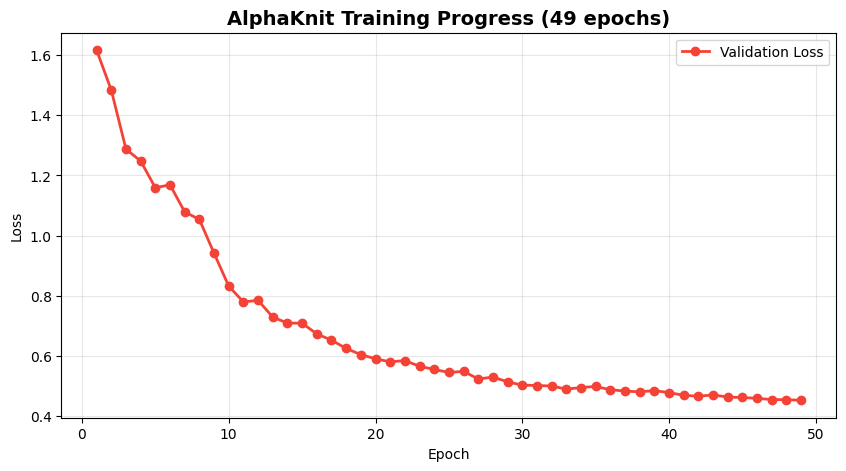

In [ ]:
import os
import torch
import matplotlib.pyplot as plt

ckpt_dir = TRAIN_CONFIG["checkpoint_dir"]
ckpt_files = sorted([f for f in os.listdir(ckpt_dir) if f.startswith('epoch_') and f.endswith('.pt')])

if not ckpt_files:
    print("⚠️ No checkpoints found yet. Train for at least 1 epoch!")
else:
    epochs_list = []
    val_losses = []

    print(f"✅ Found {len(ckpt_files)} checkpoints. Extracting metrics...")
    for f in ckpt_files:
        ckpt = torch.load(os.path.join(ckpt_dir, f), map_location="cpu", weights_only=True)
        epochs_list.append(ckpt["epoch"])
        val_losses.append(ckpt["val_loss"])

    plt.figure(figsize=(10, 5))
    plt.plot(epochs_list, val_losses, 'o-', color="#F44336", label="Validation Loss", linewidth=2)
    plt.title(f"AlphaKnit Training Progress ({len(epochs_list)} epochs)", fontsize=14, fontweight="bold")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

In [ ]:
if history:
    epochs_list = [h["epoch"] for h in history]

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle("AlphaKnit Training Dashboard", fontsize=16, fontweight="bold")

    # 1. Loss curves
    ax = axes[0, 0]
    ax.plot(epochs_list, [h["train_loss"] for h in history], label="Train", color="#2196F3")
    ax.plot(epochs_list, [h["val_loss"] for h in history], label="Val", color="#F44336", ls="--")
    ax.set_title("Loss"); ax.set_xlabel("Epoch"); ax.legend(); ax.grid(True, alpha=0.3)

    # 2. Entropy
    ax = axes[0, 1]
    ax.plot(epochs_list, [h.get("train_entropy", 0) for h in history], color="#9C27B0")
    ax.set_title("Token Entropy"); ax.set_xlabel("Epoch"); ax.grid(True, alpha=0.3)

    # 3. Structural Accuracy
    ax = axes[0, 2]
    ax.plot(epochs_list, [h.get("struct_acc", 0) for h in history], color="#4CAF50")
    ax.set_title("Structural Top-1 Acc"); ax.set_xlabel("Epoch"); ax.set_ylim(0, 1); ax.grid(True, alpha=0.3)

    # 4. Compile Success Rate
    ax = axes[1, 0]
    ce = [h["epoch"] for h in history if "compile_success_rate" in h]
    cr = [h["compile_success_rate"] for h in history if "compile_success_rate" in h]
    if ce: ax.plot(ce, cr, 'o-', color="#FF9800", ms=6)
    ax.set_title("Compile Success Rate"); ax.set_xlabel("Epoch"); ax.set_ylim(0, 1); ax.grid(True, alpha=0.3)

    # 5. Phase Lag
    ax = axes[1, 1]
    ax.plot(epochs_list, [h.get("phase_lag", 0) for h in history], color="#00BCD4")
    ax.set_title("Phase Lag"); ax.set_xlabel("Epoch"); ax.grid(True, alpha=0.3)

    # 6. PDI & Tension
    ax = axes[1, 2]
    ax.plot(epochs_list, [h.get("train_pdi", 0) for h in history], label="PDI", color="#E91E63")
    ax.plot(epochs_list, [h.get("train_tension", 0) for h in history], label="Tension", color="#795548")
    ax.set_title("PDI & Tension"); ax.set_xlabel("Epoch"); ax.legend(); ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(TRAIN_CONFIG["checkpoint_dir"], "training_dashboard.png"), dpi=150)
    plt.show()
    print("📊 Dashboard saved!")

## 8. 💾 Export Best Model

In [ ]:
# Kiểm tra các checkpoints
ckpt_dir = TRAIN_CONFIG["checkpoint_dir"]
ckpt_files = sorted([f for f in os.listdir(ckpt_dir) if f.endswith('.pt')])

print(f"📁 Checkpoints in {ckpt_dir}:")
for f in ckpt_files:
    size_mb = os.path.getsize(os.path.join(ckpt_dir, f)) / 1e6
    print(f"   {f} ({size_mb:.1f} MB)")

📁 Checkpoints in /content/drive/MyDrive/AlphaKnit/checkpoints:
   best_model_colab_v6.6F.pt (11.3 MB)
   epoch_001.pt (11.3 MB)
   epoch_002.pt (11.3 MB)
   epoch_003.pt (11.3 MB)
   epoch_004.pt (11.3 MB)
   epoch_005.pt (11.3 MB)
   epoch_006.pt (11.3 MB)
   epoch_007.pt (11.3 MB)
   epoch_008.pt (11.3 MB)
   epoch_009.pt (11.3 MB)
   epoch_010.pt (11.3 MB)
   epoch_011.pt (11.3 MB)
   epoch_012.pt (11.3 MB)
   epoch_013.pt (11.3 MB)
   epoch_014.pt (11.3 MB)
   epoch_015.pt (11.3 MB)
   epoch_016.pt (11.3 MB)
   epoch_017.pt (11.3 MB)
   epoch_018.pt (11.3 MB)
   epoch_019.pt (11.3 MB)
   epoch_020.pt (11.3 MB)
   epoch_021.pt (11.3 MB)
   epoch_022.pt (11.3 MB)
   epoch_023.pt (11.3 MB)
   epoch_024.pt (11.3 MB)
   epoch_025.pt (11.3 MB)
   epoch_026.pt (11.3 MB)
   epoch_027.pt (11.3 MB)
   epoch_028.pt (11.3 MB)
   epoch_029.pt (11.3 MB)
   epoch_030.pt (11.3 MB)
   epoch_031.pt (11.3 MB)
   epoch_032.pt (11.3 MB)
   epoch_033.pt (11.3 MB)
   epoch_034.pt (11.3 MB)
   epoch_035.p

In [ ]:
# Download best model về máy local
from google.colab import files

best_model_path = os.path.join(ckpt_dir, f"best_model_{TRAIN_CONFIG['run_name']}.pt")
if os.path.exists(best_model_path):
    ckpt = torch.load(best_model_path, map_location="cpu", weights_only=True)
    print(f"Best model — Epoch: {ckpt['epoch']}, Val Loss: {ckpt['val_loss']:.4f}")
    files.download(best_model_path)
else:
    print("⚠️ Best model not found. Train first!")

Best model — Epoch: 49, Val Loss: 0.4528


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 9. 🔬 Quick Inference Test

In [ ]:
# Load best model và test inference
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = KnittingTransformer(
    d_model=TRAIN_CONFIG["d_model"],
    n_heads=TRAIN_CONFIG["n_heads"],
    n_layers=TRAIN_CONFIG["n_layers"],
    ffn_dim=TRAIN_CONFIG["ffn_dim"],
).to(device)

best_model_path = os.path.join(ckpt_dir, f"best_model_{TRAIN_CONFIG['run_name']}.pt")
if os.path.exists(best_model_path):
    ckpt = torch.load(best_model_path, map_location=device, weights_only=True)
    model.load_state_dict(ckpt["model_state"])
    model.eval()
    print(f"✅ Model loaded (Epoch {ckpt['epoch']}, Val Loss {ckpt['val_loss']:.4f})")

    # Load 1 sample từ shard để test
    import tarfile, io
    base_dir = DATASET_DIR.split('{')[0] if '{' in DATASET_DIR else DATASET_DIR + '/'
    first_shard = base_dir + "0000.tar" if '.tar' in DATASET_DIR else None

    if first_shard and os.path.exists(first_shard):
        with tarfile.open(first_shard, 'r') as tar:
            member = tar.getmembers()[0]
            f = tar.extractfile(member)
            sample = torch.load(io.BytesIO(f.read()), map_location='cpu', weights_only=False)
        pc = sample['pc'].unsqueeze(0).to(device)
    elif os.path.isdir(DATASET_DIR):
        dataset = KnittingDataset(DATASET_DIR)
        sample = dataset[0]
        pc = sample['point_cloud'].unsqueeze(0).to(device)
    else:
        pc = None
        print("⚠️ No dataset found for inference test.")

    if pc is not None:
        with torch.no_grad():
            pred_tuples = model.greedy_decode(pc, max_len=config.MAX_SEQ_LEN)

        pred = pred_tuples[0]
        print(f"\n📋 Generated sequence ({len(pred)} tuples):")
        for i, (t, p1, p2) in enumerate(pred[:20]):
            token_name = config.ID_TO_TOKEN.get(t, f"<ID:{t}>")
            print(f"   [{i:3d}] {token_name:8s} (p1={p1}, p2={p2})")
        if len(pred) > 20:
            print(f"   ... ({len(pred) - 20} more tuples)")

        # Compile test
        try:
            from alphaknit.compiler import KnittingCompiler
            compiler = KnittingCompiler()
            tokens = [f"{config.ID_TO_TOKEN.get(t, '<UNK>')}({p1},{p2})" for t, p1, p2 in pred]
            graph = compiler.compile(tokens)
            print(f"\n✅ Compile SUCCESS! Graph: {len(graph.nodes)} nodes.")
        except Exception as e:
            print(f"\n❌ Compile failed: {e}")
else:
    print("⚠️ No trained model found. Run training first!")

✅ Model loaded (Epoch 49, Val Loss 0.4528)

📋 Generated sequence (300 tuples):
   [  0] mr_6     (p1=0, p2=0)
   [  1] inc      (p1=7, p2=0)
   [  2] inc      (p1=7, p2=0)
   [  3] inc      (p1=7, p2=0)
   [  4] inc      (p1=8, p2=0)
   [  5] inc      (p1=8, p2=0)
   [  6] inc      (p1=9, p2=0)
   [  7] inc      (p1=9, p2=0)
   [  8] inc      (p1=10, p2=0)
   [  9] inc      (p1=10, p2=0)
   [ 10] inc      (p1=11, p2=0)
   [ 11] inc      (p1=11, p2=0)
   [ 12] inc      (p1=12, p2=0)
   [ 13] sc       (p1=12, p2=0)
   [ 14] sc       (p1=12, p2=0)
   [ 15] sc       (p1=12, p2=0)
   [ 16] sc       (p1=12, p2=0)
   [ 17] sc       (p1=12, p2=0)
   [ 18] sc       (p1=12, p2=0)
   [ 19] sc       (p1=12, p2=0)
   ... (280 more tuples)

✅ Compile SUCCESS! Graph: 305 nodes.
